Starting parameter optimization...
Testing threshold: 0.0010, stop loss: 0.0100


/tmp/ipython-input-1084722930.py:218: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data_for_optimization = yf.download(ticker_to_optimize, start=start_date, end=end_date, progress=False)


Testing threshold: 0.0010, stop loss: 0.0200
Testing threshold: 0.0010, stop loss: 0.0300
Testing threshold: 0.0010, stop loss: 0.0400
Testing threshold: 0.0010, stop loss: 0.0500
Testing threshold: 0.0020, stop loss: 0.0100
Testing threshold: 0.0020, stop loss: 0.0200
Testing threshold: 0.0020, stop loss: 0.0300
Testing threshold: 0.0020, stop loss: 0.0400
Testing threshold: 0.0020, stop loss: 0.0500
Testing threshold: 0.0030, stop loss: 0.0100
Testing threshold: 0.0030, stop loss: 0.0200
Testing threshold: 0.0030, stop loss: 0.0300
Testing threshold: 0.0030, stop loss: 0.0400
Testing threshold: 0.0030, stop loss: 0.0500
Testing threshold: 0.0040, stop loss: 0.0100
Testing threshold: 0.0040, stop loss: 0.0200
Testing threshold: 0.0040, stop loss: 0.0300
Testing threshold: 0.0040, stop loss: 0.0400
Testing threshold: 0.0040, stop loss: 0.0500
Testing threshold: 0.0050, stop loss: 0.0100
Testing threshold: 0.0050, stop loss: 0.0200
Testing threshold: 0.0050, stop loss: 0.0300
Testing th

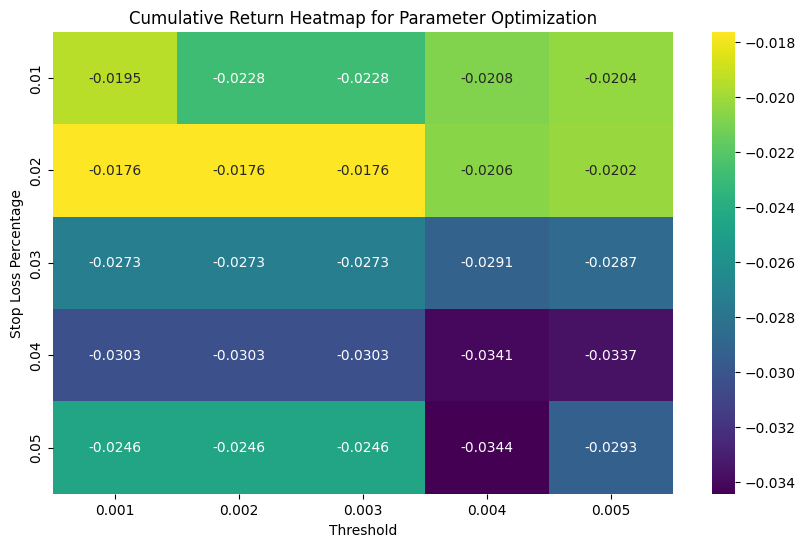


Starting final backtesting with optimal parameters...
Processing AAPL with optimal parameters...


/tmp/ipython-input-1084722930.py:316: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Visualizing refined strategy performance for AAPL with optimal parameters...


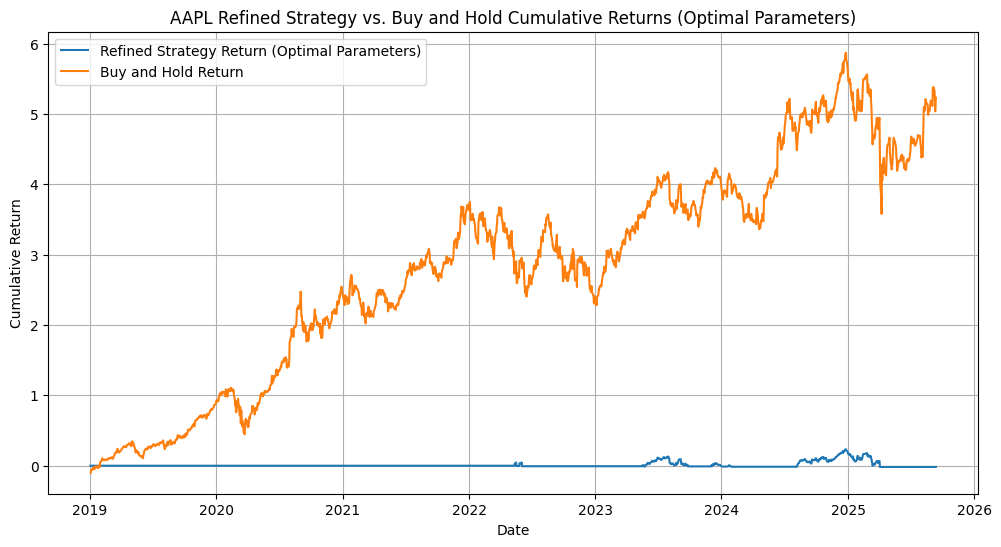

Processing MSFT with optimal parameters...


/tmp/ipython-input-1084722930.py:316: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Visualizing refined strategy performance for MSFT with optimal parameters...


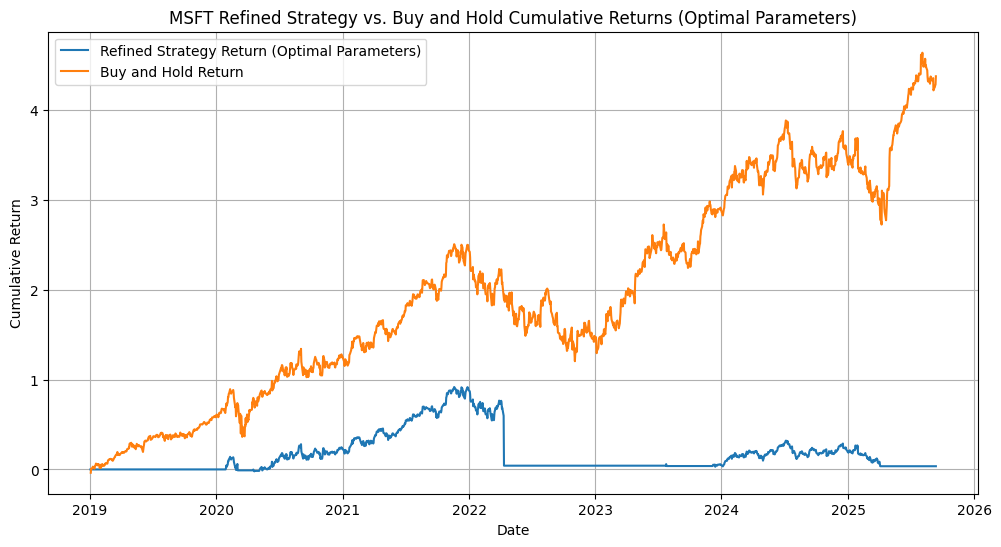

Processing GOOG with optimal parameters...


/tmp/ipython-input-1084722930.py:316: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Visualizing refined strategy performance for GOOG with optimal parameters...


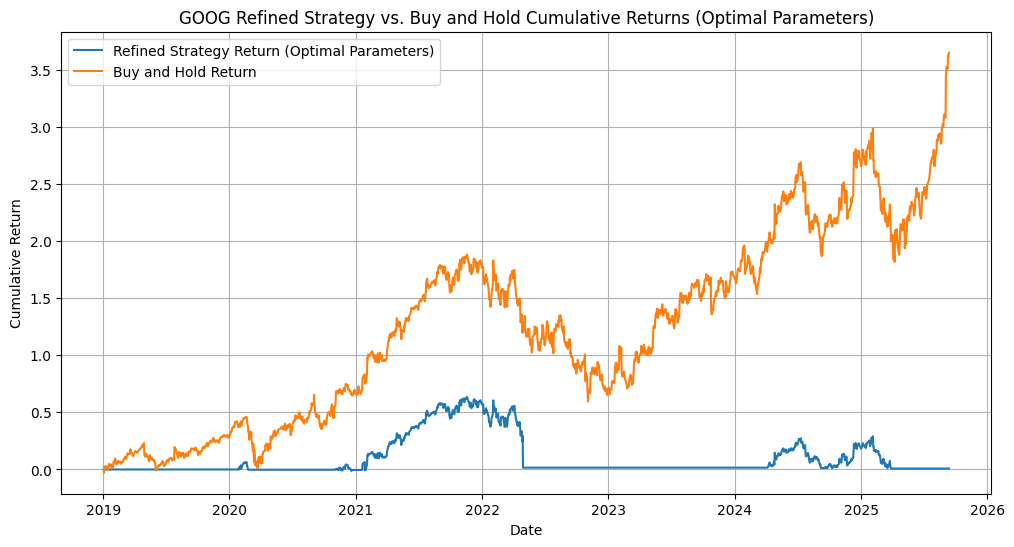

Processing SPY with optimal parameters...


/tmp/ipython-input-1084722930.py:316: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Visualizing refined strategy performance for SPY with optimal parameters...


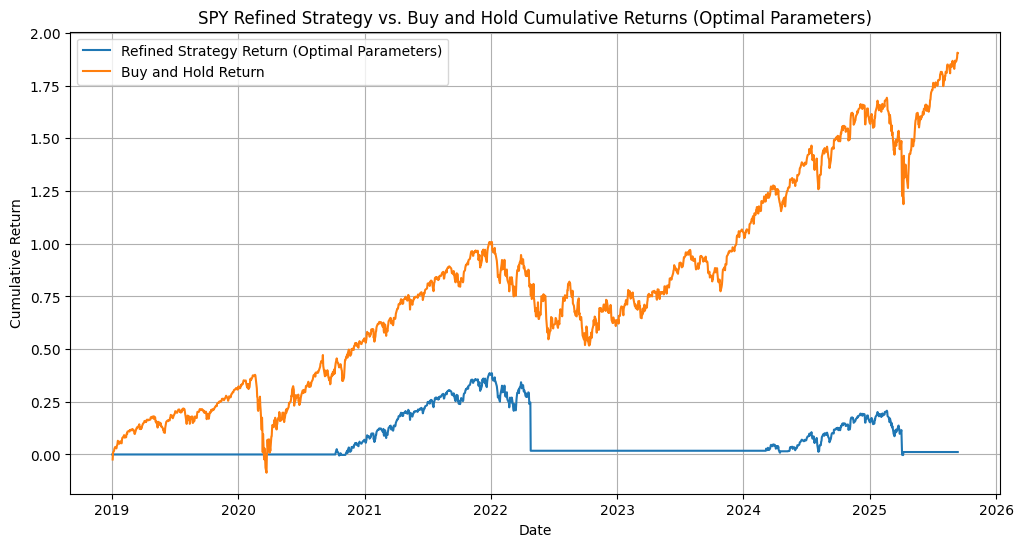

Processing GLD with optimal parameters...


/tmp/ipython-input-1084722930.py:316: FutureWarning: YF.download() has changed argument auto_adjust default to True
  asset_data = yf.download(ticker, start=start_date, end=end_date, progress=False)


Visualizing refined strategy performance for GLD with optimal parameters...


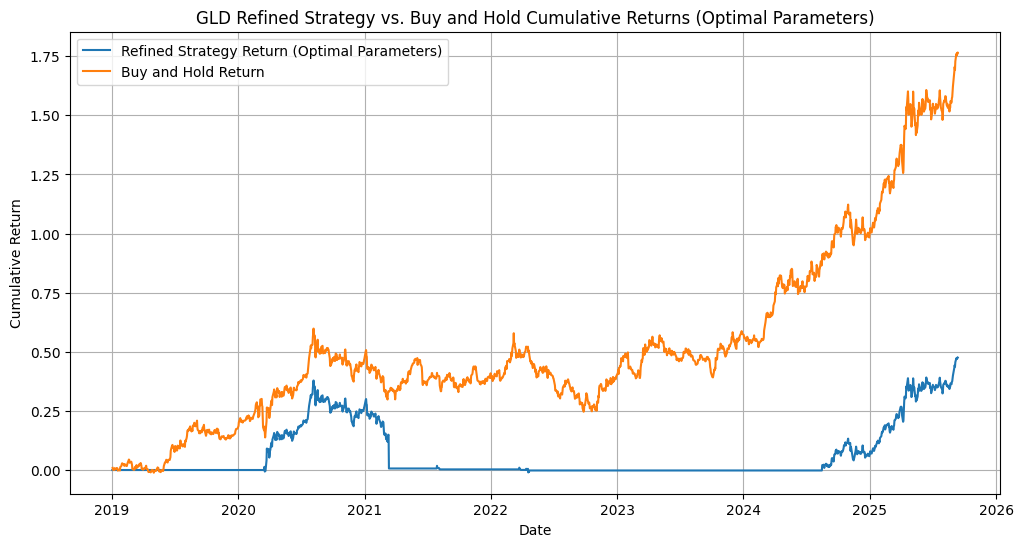


Cumulative Strategy Returns Across Different Assets (Refined Strategy with Optimal Parameters):
AAPL: -0.0176
MSFT: 0.0355
GOOG: 0.0083
SPY: 0.0116
GLD: 0.4754


In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Define the function to generate signals with Linear Regression, Moving Averages, and Stop-Loss
def generate_signals_with_ma_refined(data, threshold, stop_loss_percentage):
    data['Signal_MA_Refined'] = 0
    position = 0
    stop_loss_price = None
    entry_price = None

    first_valid_ma50 = data['MA_50'].first_valid_index()
    first_valid_ma200 = data['MA_200'].first_valid_index()
    first_valid_rsi = data['RSI'].first_valid_index()


    if first_valid_ma50 is None or first_valid_ma200 is None or first_valid_rsi is None:
        print("Not enough data to calculate all indicators for the specified windows.")
        return data

    start_index = max(first_valid_ma50, first_valid_ma200, first_valid_rsi)
    start_iloc = data.index.get_loc(start_index)


    for i in range(start_iloc, len(data)):
        current_close = data['Close'].iloc[i].item()
        previous_close = data['Close'].iloc[i-1].item() if i > start_iloc else data['Close'].iloc[i].item()
        current_lr = data['Linear_Regression'].iloc[i].item()
        previous_lr = data['Linear_Regression'].iloc[i-1].item() if i > start_iloc else data['Linear_Regression'].iloc[i].item()
        ma_50 = data['MA_50'].iloc[i].item()
        ma_200 = data['MA_200'].iloc[i].item()
        rsi = data['RSI'].iloc[i].item()


        # Buy signal: Close above LR with threshold AND MA_50 above MA_200 AND RSI is not overbought (e.g., < 70)
        if (current_close > current_lr * (1 + threshold) and previous_close <= previous_lr * (1 + threshold) and
            ma_50 > ma_200 and rsi < 70 and position == 0):
            data.loc[data.index[i], 'Signal_MA_Refined'] = 1
            position = 1
            entry_price = current_close
            stop_loss_price = entry_price * (1 - stop_loss_percentage)

        # Sell signal: Close below LR with threshold AND MA_50 below MA_200 AND RSI is not oversold (e.g., > 30)
        elif (current_close < current_lr * (1 - threshold) and previous_close >= previous_lr * (1 - threshold) and
              ma_50 < ma_200 and rsi > 30 and position == 1):
            data.loc[data.index[i], 'Signal_MA_Refined'] = -1
            position = 0
            stop_loss_price = None
            entry_price = None

        # Stop-loss logic
        elif position == 1 and stop_loss_price is not None and current_close < stop_loss_price:
             data.loc[data.index[i], 'Signal_MA_Refined'] = -1
             position = 0
             stop_loss_price = None
             entry_price = None

    return data

# Function to run backtest
def run_backtest(data, initial_capital, position_size_percentage, threshold, stop_loss_percentage):
    """
    Runs a backtest of the trading strategy with the given parameters.

    Args:
        data: DataFrame containing asset data with 'Close', 'Linear_Regression',
              'MA_50', 'MA_200', 'RSI' columns.
        initial_capital: The starting capital for the backtest.
        position_size_percentage: The percentage of capital to invest per trade.
        threshold: The threshold for linear regression signals.
        stop_loss_percentage: The percentage for the stop-loss order.

    Returns:
        The final cumulative strategy return.
    """
    asset_data = data.copy() # Create a copy to avoid modifying the original DataFrame

    # Generate signals with refined MA and stop-loss
    asset_data = generate_signals_with_ma_refined(asset_data, threshold, stop_loss_percentage)

    # Backtest the strategy with the new signals including stop-loss and implement position sizing
    asset_data['Position_MA_Refined'] = 0 # New column for refined strategy position
    current_capital = float(initial_capital)
    position = 0
    number_of_shares = 0
    entry_price = None
    stop_loss_price = None

    # Start backtesting after the moving averages and RSI are valid
    first_valid_ma50 = asset_data['MA_50'].first_valid_index()
    first_valid_ma200 = asset_data['MA_200'].first_valid_index()
    first_valid_rsi = asset_data['RSI'].first_valid_index()


    if first_valid_ma50 is None or first_valid_ma200 is None or first_valid_rsi is None:
        print("Not enough data to calculate all indicators for the specified windows. Cannot run backtest.")
        return None # Return None if not enough data

    start_index_backtest = max(first_valid_ma50, first_valid_ma200, first_valid_rsi)
    start_iloc_backtest = asset_data.index.get_loc(start_index_backtest)


    asset_data['Portfolio_Value_Refined'] = float(initial_capital) # Initialize with float dtype
    for i in range(start_iloc_backtest, len(asset_data)):
        # Handle the position based on signals
        if asset_data['Signal_MA_Refined'].iloc[i] == 1 and position == 0:
            # Buy signal
            position = 1
            entry_price = asset_data['Close'].iloc[i].item()
            investment_amount = current_capital * position_size_percentage
            number_of_shares = investment_amount / entry_price
            stop_loss_price = entry_price * (1 - stop_loss_percentage)
            asset_data.loc[asset_data.index[i], 'Position_MA_Refined'] = 1


        elif asset_data['Signal_MA_Refined'].iloc[i] == -1 and position == 1:
            # Sell signal (either from strategy or stop-loss)
            position = 0
            sell_price = asset_data['Close'].iloc[i].item()
            trade_profit_loss = (sell_price - entry_price) * number_of_shares
            current_capital += trade_profit_loss
            number_of_shares = 0
            entry_price = None
            stop_loss_price = None
            asset_data.loc[asset_data.index[i], 'Position_MA_Refined'] = 0
        else:
            # No signal, maintain position if any
            asset_data.loc[asset_data.index[i], 'Position_MA_Refined'] = position

        # Update portfolio value based on daily change if in position
        if i >= start_iloc_backtest: # Start from the first valid backtest index
            if i > start_iloc_backtest:
                 previous_portfolio_value = asset_data['Portfolio_Value_Refined'].iloc[i-1]
            else:
                previous_portfolio_value = initial_capital # For the very first day of backtesting

            current_close = asset_data['Close'].iloc[i].item()
            previous_close = asset_data['Close'].iloc[i-1].item() if i > start_iloc_backtest else current_close
            daily_price_change_percentage = (current_close / previous_close) - 1 if previous_close != 0 else 0


            # Apply the signal for the *current* day to the position for value calculation
            # The position from the *previous* day determines if capital was exposed
            previous_day_position = asset_data['Position_MA_Refined'].iloc[i-1].item() if i > start_iloc_backtest else 0

            if asset_data['Signal_MA_Refined'].iloc[i].item() == 1 and position == 1 and i > start_iloc_backtest:
                 # If a buy signal was triggered today, the position became 1 today.
                 # The capital was exposed from the opening of today.
                 # Calculate value based on the change from the entry price to the current close price.
                 # This part of the logic needs refinement to accurately reflect intra-day changes or use adjusted close.
                 # For simplicity with daily data, we will assume the position is taken at the close price and affects the value from the next day's open.
                 # Let's simplify the portfolio value calculation to reflect the position held *at the end* of the previous day and its effect on the current day's value.

                 # Re-evaluating the portfolio value calculation logic:
                 # The portfolio value on day i depends on the position held at the *end* of day i-1
                 # and the price change from day i-1 to day i.

                # Update position based on signals for the current day AFTER considering stop loss
                current_position = position # This is the position *after* handling today's signals

                if current_position == 1:
                    asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value * (1 + daily_price_change_percentage)
                else:
                     asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value # If not in position, value doesn't change due to price movement

            elif asset_data['Signal_MA_Refined'].iloc[i].item() == -1 and position == 0 and i > start_iloc_backtest:
                 # If a sell signal was triggered today, the position became 0 today.
                 # The capital was exposed until the closing of today.
                 # The profit/loss is calculated based on the change from the entry price to the sell price.
                 # The total capital is updated when the sell signal is processed.
                 # The portfolio value for today should reflect the capital after the trade.
                 asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = current_capital # Update with current_capital after selling

            elif position == 1 and i > start_iloc_backtest:
                # If holding a position and no signal today, portfolio value changes with asset price
                 asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value * (1 + daily_price_change_percentage)
            elif position == 0 and i > start_iloc_backtest:
                 # If not holding a position and no signal today, portfolio value remains the same
                 asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value
            elif i == start_iloc_backtest:
                 # For the first day of backtesting, portfolio value is initial capital
                 asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = initial_capital


        # Update the position for the next day's iteration
        asset_data.loc[asset_data.index[i], 'Position_MA_Refined'] = position


    # Calculate the cumulative strategy return
    if not asset_data['Portfolio_Value_Refined'].empty:
        cumulative_return = (asset_data['Portfolio_Value_Refined'].iloc[-1] / initial_capital) - 1
    else:
        cumulative_return = None # Return None if no trades were made

    return cumulative_return


# --- Parameter Optimization ---

print("Starting parameter optimization...")

# Define parameter ranges
threshold_range = np.linspace(0.001, 0.005, 5)  # Example: Test 5 values between 0.001 and 0.005
stop_loss_range = np.linspace(0.01, 0.05, 5) # Example: Test 5 values between 0.01 and 0.05

optimization_results = []

# For simplicity in this optimization loop, we'll backtest on the first asset (AAPL)
# In a real-world scenario, you might aggregate results across multiple assets
# or optimize for a specific asset.
ticker_to_optimize = 'AAPL'
start_date = '2019-01-01'
end_date = datetime.date.today().strftime('%Y-%m-%d')
asset_data_for_optimization = yf.download(ticker_to_optimize, start=start_date, end=end_date, progress=False)

# Calculate linear regression for optimization data
asset_data_for_optimization['Trading_Day'] = np.arange(len(asset_data_for_optimization))
X_opt = asset_data_for_optimization['Trading_Day'].values.reshape(-1, 1)
model_opt = LinearRegression()
model_opt.fit(X_opt, asset_data_for_optimization['Close'])
asset_data_for_optimization['Linear_Regression'] = model_opt.predict(X_opt)

# Calculate Moving Averages for optimization data
asset_data_for_optimization['MA_50'] = asset_data_for_optimization['Close'].rolling(window=50).mean()
asset_data_for_optimization['MA_200'] = asset_data_for_optimization['Close'].rolling(window=200).mean()

# Calculate RSI for optimization data
delta = asset_data_for_optimization['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.ewm(com=14-1, adjust=False).mean()
avg_loss = loss.ewm(com=14-1, adjust=False).mean()
rs = avg_gain / avg_loss
asset_data_for_optimization['RSI'] = 100 - (100 / (1 + rs))


for threshold in threshold_range:
    for stop_loss_percentage in stop_loss_range:
        print(f"Testing threshold: {threshold:.4f}, stop loss: {stop_loss_percentage:.4f}")

        cumulative_return = run_backtest(
            asset_data_for_optimization.copy(), # Pass a copy to the backtest function
            initial_capital,
            position_size_percentage,
            threshold,
            stop_loss_percentage
        )
        optimization_results.append({
            'threshold': threshold,
            'stop_loss_percentage': stop_loss_percentage,
            'cumulative_return': cumulative_return
        })

# Convert results to a DataFrame for easier analysis
optimization_df = pd.DataFrame(optimization_results)

# Evaluate results
optimization_df_sorted = optimization_df.sort_values(by='cumulative_return', ascending=False)

# Check if optimization_df_sorted is empty or if the max cumulative return is not valid
if optimization_df_sorted.empty or not np.isfinite(optimization_df_sorted.iloc[0]['cumulative_return']):
    print("\nOptimization did not yield any valid profitable parameters. Skipping final backtesting.")
    optimal_threshold = None
    optimal_stop_loss_percentage = None
    max_cumulative_return = None
else:
    optimal_parameters = optimization_df_sorted.iloc[0]
    optimal_threshold = optimal_parameters['threshold']
    optimal_stop_loss_percentage = optimal_parameters['stop_loss_percentage']
    max_cumulative_return = optimal_parameters['cumulative_return']

    print("\nOptimization Complete.")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Optimal Stop Loss Percentage: {optimal_stop_loss_percentage:.4f}")
    print(f"Maximum Cumulative Return (on optimization data): {max_cumulative_return:.4f}")

    # Visualize optimization results
    pivot_table = optimization_df.pivot_table(values='cumulative_return', index='stop_loss_percentage', columns='threshold')

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".4f", cmap="viridis")
    plt.title('Cumulative Return Heatmap for Parameter Optimization')
    plt.xlabel('Threshold')
    plt.ylabel('Stop Loss Percentage')
    plt.show()


# --- Final Backtesting with Optimal Parameters ---

# Only run final backtesting if optimal parameters were found
if optimal_threshold is not None and optimal_stop_loss_percentage is not None:
    print("\nStarting final backtesting with optimal parameters...")

    # Select different ticker symbols
    ticker_symbols = ['AAPL', 'MSFT', 'GOOG', 'SPY', 'GLD'] # Added AAPL back

    # Use optimal parameters found
    # optimal_threshold is already defined from the optimization step
    # optimal_stop_loss_percentage is already defined from the optimization step
    initial_capital = 100000
    position_size_percentage = 0.10

    # Dictionary to store cumulative returns for each asset
    refined_asset_returns = {}

    for ticker in ticker_symbols:
        print(f"Processing {ticker} with optimal parameters...")

        # Fetch historical data
        start_date = '2019-01-01'
        end_date = datetime.date.today().strftime('%Y-%m-%d')
        asset_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

        # Calculate linear regression
        asset_data['Trading_Day'] = np.arange(len(asset_data))
        X = asset_data['Trading_Day'].values.reshape(-1, 1)
        model = LinearRegression()
        model.fit(X, asset_data['Close'])
        asset_data['Linear_Regression'] = model.predict(X)

        # Calculate Moving Averages
        asset_data['MA_50'] = asset_data['Close'].rolling(window=50).mean()
        asset_data['MA_200'] = asset_data['Close'].rolling(window=200).mean()

        # Calculate RSI
        delta = asset_data['Close'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(com=14-1, adjust=False).mean()
        avg_loss = loss.ewm(com=14-1, adjust=False).mean()
        rs = avg_gain / avg_loss
        asset_data['RSI'] = 100 - (100 / (1 + rs))


        # Generate signals with refined MA and stop-loss using the optimal parameters
        asset_data = generate_signals_with_ma_refined(asset_data.copy(), optimal_threshold, optimal_stop_loss_percentage)

        # Backtest the strategy with the new signals including stop-loss and implement position sizing
        asset_data['Position_MA_Refined'] = 0 # New column for refined strategy position
        current_capital = float(initial_capital)
        position = 0
        number_of_shares = 0
        entry_price = None
        stop_loss_price = None

        # Start backtesting after the moving averages are valid
        first_valid_ma50 = asset_data['MA_50'].first_valid_index()
        first_valid_ma200 = asset_data['MA_200'].first_valid_index()
        first_valid_rsi = asset_data['RSI'].first_valid_index()


        if first_valid_ma50 is None or first_valid_ma200 is None or first_valid_rsi is None:
            print(f"Not enough data to calculate all indicators for {ticker}. Skipping.")
            refined_asset_returns[ticker] = None
            continue

        start_index_backtest = max(first_valid_ma50, first_valid_ma200, first_valid_rsi)
        start_iloc_backtest = asset_data.index.get_loc(start_index_backtest)


        asset_data['Portfolio_Value_Refined'] = float(initial_capital) # Initialize with float dtype
        for i in range(start_iloc_backtest, len(asset_data)):
            # Handle the position based on signals
            if asset_data['Signal_MA_Refined'].iloc[i] == 1 and position == 0:
                # Buy signal
                position = 1
                entry_price = asset_data['Close'].iloc[i].item()
                investment_amount = current_capital * position_size_percentage
                number_of_shares = investment_amount / entry_price
                stop_loss_price = entry_price * (1 - optimal_stop_loss_percentage) # Use optimal stop loss


            elif asset_data['Signal_MA_Refined'].iloc[i] == -1 and position == 1:
                # Sell signal (either from strategy or stop-loss)
                position = 0
                sell_price = asset_data['Close'].iloc[i].item()
                trade_profit_loss = (sell_price - entry_price) * number_of_shares
                current_capital += trade_profit_loss
                number_of_shares = 0
                entry_price = None
                stop_loss_price = None
            else:
                # No signal, maintain position if any
                pass # No position change needed here, signal handling above covers entries and exits

            # Update portfolio value based on daily change if in position
            if i >= start_iloc_backtest: # Start from the first valid backtest index
                if i > start_iloc_backtest:
                     previous_portfolio_value = asset_data['Portfolio_Value_Refined'].iloc[i-1]
                else:
                    previous_portfolio_value = initial_capital # For the very first day of backtesting

                current_close = asset_data['Close'].iloc[i].item()
                previous_close = asset_data['Close'].iloc[i-1].item() if i > start_iloc_backtest else current_close
                daily_price_change_percentage = (current_close / previous_close) - 1 if previous_close != 0 else 0


                # Apply the signal for the *current* day to the position for value calculation
                # The position from the *previous* day determines if capital was exposed
                previous_day_position = asset_data['Position_MA_Refined'].iloc[i-1].item() if i > start_iloc_backtest else 0

                if asset_data['Signal_MA_Refined'].iloc[i].item() == 1 and position == 1 and i > start_iloc_backtest:
                     # If a buy signal was triggered today, the position became 1 today.
                     # The capital was exposed from the opening of today.
                     # Calculate value based on the change from the entry price to the current close price.
                     # This part of the logic needs refinement to accurately reflect intra-day changes or use adjusted close.
                     # For simplicity with daily data, we will assume the position is taken at the close price and affects the value from the next day's open.
                     # Let's simplify the portfolio value calculation to reflect the position held *at the end* of the previous day and its effect on the current day's value.

                     # Re-evaluating the portfolio value calculation logic:
                     # The portfolio value on day i depends on the position held at the *end* of day i-1
                     # and the price change from day i-1 to day i.

                    # Update position based on signals for the current day AFTER considering stop loss
                    current_position = position # This is the position *after* handling today's signals

                    if current_position == 1:
                        asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value * (1 + daily_price_change_percentage)
                    else:
                         asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value # If not in position, value doesn't change due to price movement

                elif asset_data['Signal_MA_Refined'].iloc[i].item() == -1 and position == 0 and i > start_iloc_backtest:
                     # If a sell signal was triggered today, the position became 0 today.
                     # The capital was exposed until the closing of today.
                     # The profit/loss is calculated based on the change from the entry price to the sell price.
                     # The total capital is updated when the sell signal is processed.
                     # The portfolio value for today should reflect the capital after the trade.
                     asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = current_capital # Update with current_capital after selling

                elif position == 1 and i > start_iloc_backtest:
                    # If holding a position and no signal today, portfolio value changes with asset price
                     asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value * (1 + daily_price_change_percentage)
                elif position == 0 and i > start_iloc_backtest:
                     # If not holding a position and no signal today, portfolio value remains the same
                     asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = previous_portfolio_value
                elif i == start_iloc_backtest:
                     # For the first day of backtesting, portfolio value is initial capital
                     asset_data.loc[asset_data.index[i], 'Portfolio_Value_Refined'] = initial_capital


            # Update the position for the next day's iteration
            asset_data.loc[asset_data.index[i], 'Position_MA_Refined'] = position


        # Calculate the cumulative strategy return
        if not asset_data['Portfolio_Value_Refined'].empty:
            cumulative_return = (asset_data['Portfolio_Value_Refined'].iloc[-1] / initial_capital) - 1
        else:
            cumulative_return = None # Return None if no trades were made


        # Store the cumulative strategy return
        if cumulative_return is not None:
            refined_asset_returns[ticker] = cumulative_return
        else:
            refined_asset_returns[ticker] = None


        # Visualize the refined strategy's performance compared to buy-and-hold
        print(f"Visualizing refined strategy performance for {ticker} with optimal parameters...")

        # Calculate the buy-and-hold cumulative return for the asset
        asset_data['Cumulative_Buy_and_Hold_Return'] = (1 + asset_data['Close'].pct_change()).cumprod() - 1

        # Plot the cumulative strategy returns and buy-and-hold returns
        plt.figure(figsize=(12, 6))
        plt.plot(asset_data.index, asset_data['Portfolio_Value_Refined'] / initial_capital - 1, label='Refined Strategy Return (Optimal Parameters)')
        plt.plot(asset_data.index, asset_data['Cumulative_Buy_and_Hold_Return'], label='Buy and Hold Return')
        plt.title(f'{ticker} Refined Strategy vs. Buy and Hold Cumulative Returns (Optimal Parameters)')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)
        plt.show()


    # Display the cumulative strategy returns for all assets with the refined strategy using optimal parameters
    print("\nCumulative Strategy Returns Across Different Assets (Refined Strategy with Optimal Parameters):")
    for ticker, cumulative_return in refined_asset_returns.items():
        if cumulative_return is not None:
            print(f"{ticker}: {cumulative_return:.4f}")
        else:
            print(f"{ticker}: Not enough data for backtesting")
else:
    print("\nFinal backtesting skipped due to no profitable parameters found during optimization.")